Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/deep-image-prior')

Mounted at /content/drive


In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab*\nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab\n'

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [4]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = '/content/drive/MyDrive/deep-image-prior/data/inpainting/library.png'
mask_path = '/content/drive/MyDrive/deep-image-prior/data/inpainting/library_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [5]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [6]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

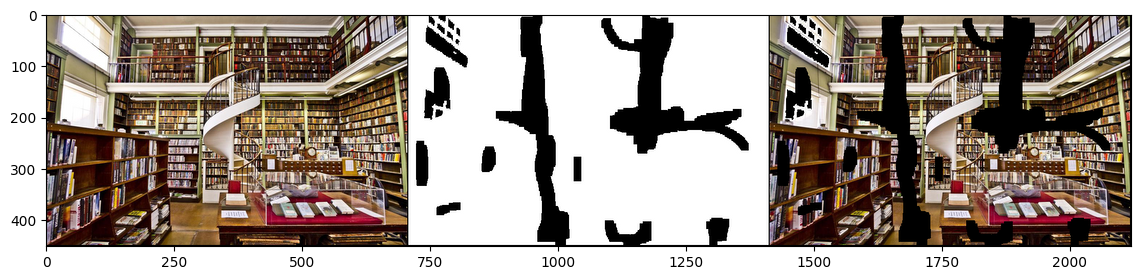

In [7]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [8]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [9]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01
    num_iter = 6001
    param_noise = False
    show_every = 600
    figsize = 5
    reg_noise_std = 0.03

    net = skip(input_depth, img_np.shape[0],
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01
    num_iter = 6001
    param_noise = False
    show_every = 600
    figsize = 5
    reg_noise_std = 0.03

    net = skip(input_depth, img_np.shape[0],
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,
               filter_size_up = 3, filter_size_down = 3,
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif 'library.png' in img_path:

    INPUT = 'noise'
    input_depth = 1

    num_iter = 6001
    show_every = 600
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True

    if 'skip' in NET_TYPE:

        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0],
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

        LR = 0.01

    elif NET_TYPE == 'UNET':

        net = UNet(num_input_channels=input_depth, num_output_channels=3,
                   feature_scale=8, more_layers=1,
                   concat_x=False, upsample_mode='deconv',
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)

        LR = 0.001
        param_noise = False

    elif NET_TYPE == 'ResNet':

        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')

        LR = 0.001
        param_noise = False

    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [10]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

def psnr(pred, gt, mask=None):
    """
    计算 PSNR
    pred, gt: torch.Tensor，shape [C,H,W]，值在 [0,1]
    mask: torch.Tensor，可选，用于只在 mask 区域计算
    """
    if mask is not None:
        diff = (pred - gt) * mask
        mse = (diff ** 2).sum() / mask.sum()
    else:
        mse = torch.mean((pred - gt) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(1.0 / mse)

def downsample(x,scale):
    return torch.nn.functional.avg_pool2d(x,kernel_size=scale,stride=scale)

def multiscale_loss(out, img, mask, scales=(1, 2, 4), weights=(1.0, 0.5, 0.25)):
    loss = 0.0
    for s, w in zip(scales, weights):
        if s == 1:
            out_s = out
            img_s = img
            mask_s = mask
        else:
            out_s = downsample(out, s)
            img_s = downsample(img, s)
            mask_s = downsample(mask, s)

        loss_s = mse(out_s * mask_s, img_s * mask_s)
        loss += w * loss_s
    return loss

Number of params: 2996467


# Main loop

In [11]:
i = 0
def closure():

    global i

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss = multiscale_loss(
        out,
        img_var,
        mask_var,
        scales=(1, 2, 4,8),
        weights=(1.0, 0.5, 0.25,0.125)
      )
    total_loss.backward()
    cur_psnr = psnr(out, img_var)
    # 或只计算缺失区域
    cur_psnr_masked = psnr(out, img_var, mask=1-mask_var)
    cur_psnr_coarse = psnr(
        downsample(out, 4),
        downsample(img_var, 4),
        mask=downsample(1-mask_var, 4)
      )

    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        print(f"Iteration {i}: {cur_psnr}, {cur_psnr_masked}, {cur_psnr_coarse}")
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

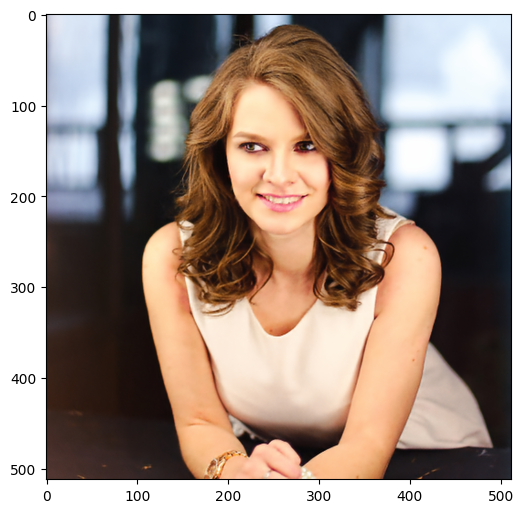

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);